# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import pdb

np.random.seed(20090425)

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0, encoding='latin-1')
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = (measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})
                    .drop('AGE', axis=1))

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head(3)

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249


Plot of cumulative cases by district

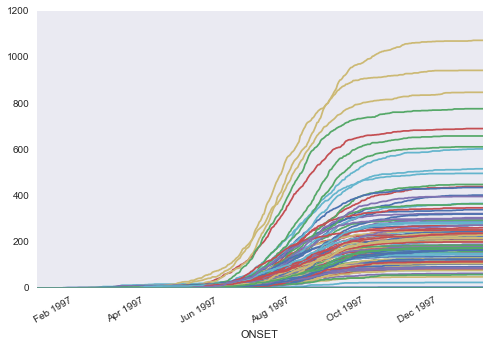

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

Age distribution of cases, by confirmation status

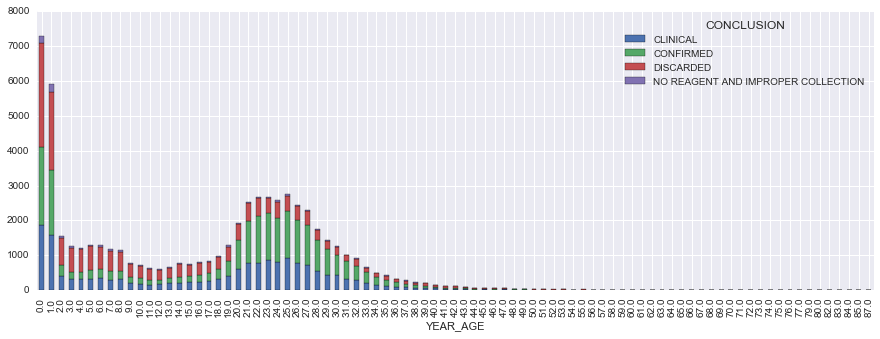

In [9]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

### Vaccination Data

In [10]:
vaccination_data = pd.read_csv('data/BrazilVaxRecords.csv', index_col=0)
vaccination_data.head()

,BIRTHS,VAX,POP,SIA
YEAR,,,,
1980,3896442,0.57,121740438,0.0
1981,3933136,0.73,124610790,0.0
1982,3952137,0.66,127525420,0.0
1983,3952735,0.68,130455659,0.0
1984,3935224,0.73,133364277,0.0


Calculate residual susceptibility from routine vaccination

In [11]:
vax_97 = np.r_[[0]*(1979-1921+1), vaccination_data.VAX[:17]]
n = len(vax_97)
FOI_mat = np.resize((1 - vax_97*0.9), (n,n)).T

In [12]:
vacc_susc = (1 - vax_97*0.9)[::-1]
vacc_susc[0] = 0.5

Susceptiblity accounting for SIAs

In [13]:
sia_susc = np.ones(len(vax_97))
birth_year = np.arange(1922, 1998)[::-1]
by_mask = (birth_year > 1983) & (birth_year < 1992)
sia_susc[by_mask] *= 0.2

## Compilation of cases into 2-week intervals by age class

Age classes are defined in 5-year intervals. We will combine 40+ ages into a single class.

In [14]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.YEAR_AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [15]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract lab-confirmed and clinical-confirmed subsets, with no missing county information.

In [16]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.COUNTY.notnull()].copy()

In [17]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
confirmed = (lab_subset.CONCLUSION=='CONFIRMED').values

In [18]:
clinic_subset = measles_data[CLINICAL & measles_data.COUNTY.notnull()].copy()

Histogram of lab subset, by outcome.

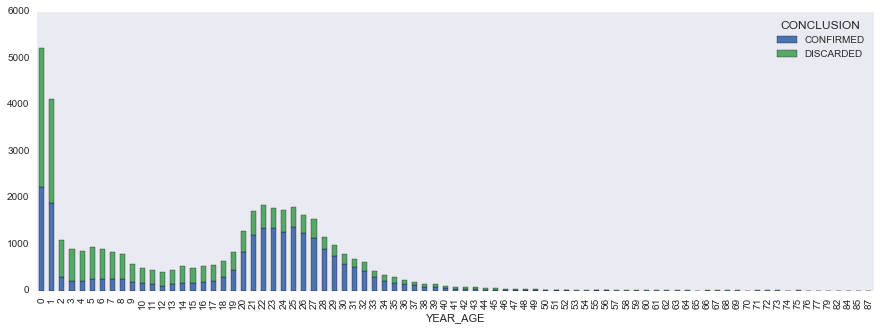

In [19]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [20]:
lab_subset.shape

(41547, 15)

Define age groups

In [21]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])
age_groups = age_group.categories
age_groups

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [22]:
age_slice_endpoints = [g[1:-1].split(',') for g in age_groups]
age_slices = [slice(int(i[0]), int(i[1])) for i in age_slice_endpoints]

Get index from full cross-tabulation to use as index for each district

In [23]:
dates_index = measles_data.groupby(['ONSET', 'AGE_GROUP']).size().unstack().index

## Cleanup of Sao Paulo population data

Match age groupings, exclude invalid districts.

In [24]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [25]:
excludes = ['BOM RETIRO']

N = sp_pop.drop(excludes).ix[unique_districts].sum().drop('Total')

In [26]:
N_age = N.iloc[:8]
N_age.index = age_groups[:-1]
N_age[age_groups[-1]] = N.iloc[8:].sum()

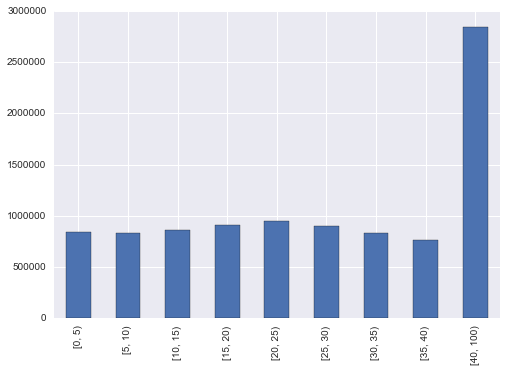

In [27]:
N_age.plot(kind='bar')

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [28]:
# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = (confirmed_data.groupby(['ONSET', 'AGE_GROUP'])
                    .size()
                    .unstack()
                    .reindex(dates_index)
                    .fillna(0)
                    .sum())

all_confirmed_cases = (confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                       .fillna(0).values.astype(int))

In [73]:
confirmed_counts_2w = (confirmed_data
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W')
                        .sum())

In [30]:
# All clinical cases, by district
clinical_counts = (clinic_subset.groupby(['ONSET', 'AGE_GROUP'])
                   .size()
                   .unstack()
                   .reindex(dates_index)
                   .fillna(0)
                   .sum())

all_clinical_cases = (clinical_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                      .fillna(0).values.astype(int))

In [72]:
clinical_counts_2w = (clinic_subset
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W')
                        .sum())

In [32]:
confirmed_counts_2w.head()

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1997-01-19,0.0,1.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0
1997-02-02,4.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
1997-02-16,4.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
1997-03-02,9.0,0.0,0.0,2.0,4.0,5.0,1.0,0.0,1.0


In [33]:
clinical_counts_2w.head()

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1997-01-19,30.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,0.0
1997-02-02,22.0,4.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0
1997-02-16,21.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0
1997-03-02,24.0,5.0,2.0,5.0,2.0,2.0,2.0,1.0,0.0


Check shape of data frame

- 28 bi-monthly intervals, 9 age groups

In [34]:
assert clinical_counts_2w.shape == (28, len(age_groups))

## Stochastic Disease Transmission Model

We will extend a simple SIR disease model, to account for confirmation status, which will be fit using MCMC.

This model fits the series of 2-week infection totals for each age group $a$ as a set of Poisson random variables:

\\[Pr(I_{a}(t) | \lambda_a(t)) = \text{Poisson}(\lambda_a(t)) \\]

Where the age-specific outbreak intensity at time $t$ is modeled as:

\\[\lambda_a(t) = S_a(t-1) \frac{I(t-1)\mathbf{B}}{N_a} \\]

where $S_a(t-1)$ is the number of susceptibles in age group $a$ in the previous time period, $I(t-1)$ an age-specific vector of the number of infected individuals in the previous time period, $\mathbf{B}$ a matrix of transmission coefficients (both within- and between-ages), and $N_a$ an estimate of the population of age-$a$ people in Sao Paulo.

The matrix $B$ was constructed from a scalar transmission parameter $\beta$, which was given a vague half-Cauchy prior (scale=25). This was used to represent within-age-group transmission, and hence placed on the diagonal of a square transmission matrix of size $A$. Off-diagonal elements, representing transmission between age groups were scaled by a decay parameter $\delta$ which was used to scale the transmission to adjacent groups according to:

\\[\beta \delta^{|a-b|}\\]

where a and b are indices of two age group. The resulting transmission matrix is parameterized as follows:

$$\begin{aligned}
\mathbf{B} = \left[{
\begin{array}{c}
  {\beta} & {\beta \delta} & {\beta \delta^2}& \ldots & {\beta \delta^{A-2}} & {\beta \delta^{A-1}}  \\
  {\beta \delta} & {\beta} &  \beta \delta & \ldots & {\beta \delta^{A-3}}  & {\beta \delta^{A-2}} \\
  {\beta \delta^2} & \beta \delta & {\beta} & \ldots & {\beta \delta^{A-4}} & {\beta \delta^{A-3}} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {\beta \delta^{A-2}} & {\beta \delta^{A-3}} & {\beta \delta^{A-4}} & \ldots &  {\beta} & \beta \delta  \\
{\beta \delta^{A-1}} & {\beta \delta^{A-2}} & \beta \delta^{A-3} & \ldots & \beta \delta &  {\beta} 
\end{array}
}\right]
\end{aligned}$$

The basic reproductive number $R_0$ was calculated as the largest real-valued eigenvalue of the matrix $\mathbf{B}$. To impose a mild constraint on $R_0$, we applied a Gaussian prior distribution whose 1st and 99th quantiles are 8 and 24, respectively, a reasonable range for a measles outbreak:

In [35]:
from pymc import MCMC, Matplot, AdaptiveMetropolis, MAP, Slicer
from pymc import (Uniform, DiscreteUniform, Beta, Binomial, Normal, 
                  CompletedDirichlet, Pareto,
                  Poisson, NegativeBinomial, negative_binomial_like, poisson_like,
                  Lognormal, Exponential, binomial_like,
                  TruncatedNormal, Binomial, Gamma, HalfCauchy, normal_like,
                  MvNormalCov, Bernoulli, Uninformative, 
                  Multinomial, rmultinomial, rbinomial,
                  Dirichlet, multinomial_like, uniform_like)
from pymc import (Lambda, observed, invlogit, deterministic, potential, stochastic, logit)

def measles_model(obs_date, confirmation=True, migrant=False, constrain_R=True):
    
    '''
    Confirmation sub-model
    '''
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        μ = Normal("μ", mu=0, tau=0.0001, value=[0]*len(age_classes))
        σ = HalfCauchy('σ', 0, 25, value=1)
        var = σ**2
        ρ = Uniform('ρ', -1, 1, value=0)

        # Build variance-covariance matrix with first-order correlation 
        # among age classes
        @deterministic
        def Σ(var=var, cor=ρ):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*var*cor
            return I + E + E.T

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        β_age = MvNormalCov("β_age", mu=μ, C=Σ, value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda b=β_age: invlogit(b))

        @deterministic(trace=False)
        def p_confirm(b=β_age):
            return invlogit(b[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=confirmed, 
                                observed=True)


    '''
    Truncate data at observation period
    '''
    obs_index = clinical_counts_2w.index <= obs_date
    confirmed_obs_t = confirmed_counts_2w[obs_index].values.astype(int)
    clinical_obs_t = clinical_counts_2w[obs_index].values.astype(int)
                        
    n_periods, n_age_groups = confirmed_obs_t.shape

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = obs_index.sum() - 1
    
    if confirmation:
        
        @stochastic(dtype=int)
        def clinical_cases(value=(clinical_obs_t*0.5).astype(int), 
                            n=clinical_obs_t, p=p_age):
            # Binomial confirmation process
            return np.sum([binomial_like(xi, ni, p) for xi,ni in zip(value,n)])
        I = Lambda('I', lambda clinical=clinical_cases: 
                           clinical + confirmed_obs_t.astype(int))

        assert I.value.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I.value, 0)/ float(I.value.sum())
        
    else:
        
        I = confirmed_obs_t + clinical_obs_t

        assert I.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I, 0) / float(I.sum())
        
    
    # Calcuate age distribution from observed distribution of infecteds to date
    _age_dist = Dirichlet('_age_dist', np.ones(n_age_groups), 
                         value=age_dist_init[:-1]/age_dist_init.sum())
    age_dist = CompletedDirichlet('age_dist', _age_dist)
    
    @potential
    def age_dist_like(p=age_dist, I=I):
        return multinomial_like(I.sum(0), I.sum(), p)

    
    '''
    Disease transmission model
    '''

    # Transmission parameter
    β = HalfCauchy('β', 0, 25, value=5) #[1]*n_age_groups) 
    decay = Beta('decay', 1, 5, value=0.8)

    @deterministic
    def B(b=β, d=decay):
        b = np.ones(n_age_groups)*b
        B = b*np.eye(n_age_groups)
        for i in range(1, n_age_groups):
            B += np.diag(np.ones(n_age_groups-i)*b[i:]*d**i, k=-i) 
            B += np.diag(np.ones(n_age_groups-i)*b[:-i]*d**i, k=i)
        return B

    # Downsample annual series to observed age groups
    downsample = lambda x: np.array([x[s].mean() for s in age_slices])

    @deterministic
    def R0(B=B):
        evs = np.linalg.eigvals(B)
        return max(evs[np.isreal(evs)])
    
    if constrain_R:
        @potential
        def constrain_R0(R0=R0):
            # Weakly-informative prior to constrain R0 to be within the 
            # typical measles range
            return normal_like(R0, 16, 3.4**-2)


    A = Lambda('A', lambda R0=R0: 75./(R0 - 1))
    lt_sum = downsample(np.tril(FOI_mat).sum(0)[::-1])
    natural_susc = Lambda('natural_susc', lambda A=A: np.exp((-1/A) * lt_sum))

    @deterministic
    def p_μ(natural_susc=natural_susc): 
        return downsample(sia_susc) * downsample(vacc_susc) * natural_susc
    
    if True:
        # Following Stan manual chapter 16.2
        λ_p = Pareto('λ_p', 1.5, 0.1, value=0.5)

        a = Lambda('a', lambda mu=p_μ, lam=λ_p: mu*lam, trace=False)
        b = Lambda('b', lambda mu=p_μ, lam=λ_p: (1-mu)*lam, trace=False)

        p_susceptible = Beta('p_susceptible', a, b, value=p_μ.value)
        
    else:
        
        p_σ = HalfCauchy('p_σ', 0, 5, value=1)
        
        m = Lambda('m', lambda p=p_μ: logit(p))
        
        θ_p = Normal('theta_p', m, p_σ)
        
        p_susceptible = Lambda('p_susceptible', lambda θ_p=θ_p: invlogit(θ_p))
        

    # Estimated total initial susceptibles
    S_0 = Binomial('S_0', n=N_age.values.astype(int), p=p_susceptible)
    
    '''
    Model of migrant influx of susceptibles
    '''
    if migrant:
    
        # Data augmentation for migrant susceptibles
        imaginary_migrants = 1000000
        N_migrant = DiscreteUniform('N_migrant', 0, imaginary_migrants, value=100000)
        μ_age = Uniform('μ_age', 15, 35, value=25)
        σ_age = Uniform('σ_age', 1, 10, value=5)
        M_age = Normal('M_age', μ_age, σ_age**-2, 
                       size=imaginary_migrants, trace=False)

        @deterministic
        def M_0(M=M_age, N=N_migrant):
            # Take first N augmented susceptibles
            M_real = M[:N]
            # Drop into age groups
            M_group = pd.cut(M_real, 
                             [0, 5, 10, 15, 20, 25, 30, 35, 40, 100], 
                             right=False)
            return M_group.value_counts().values

        p_migrant = Lambda('p_migrant', lambda M_0=M_0, S_0=S_0: M_0/(M_0 + S_0))

        I_migrant = [Binomial('I_migrant_%i' % i, I[i], p_migrant) 
                             for i in range(t_obs + 1)]

        I_local = Lambda('I_local', 
                lambda I=I, I_m=I_migrant: 
                         np.array([Ii - Imi for Ii,Imi in zip(I,I_m)]))
        S = Lambda('S', lambda I=I, S_0=S_0, M_0=M_0: S_0 + M_0 - I.cumsum(0))
        S_local = Lambda('S_local', lambda I=I_local, S_0=S_0: S_0 - I.cumsum(0))


    else:

        # Remaining susceptibles at each 2-week period
        S = Lambda('S', lambda I=I, S_0=S_0: S_0 - I.cumsum(axis=0))
    
    # Check shape
    assert S.value.shape == (t_obs+1., n_age_groups)
    

    # Susceptibles at time t, by age
    S_age = Lambda('S_age', lambda S=S: S[-1].astype(int))
    
    # Force of infection
    @deterministic
    def λ(B=B, I=I, S=S): 
        return S * (I.dot(B) / N_age.values)

    # Check shape
    assert λ.value.shape == (t_obs+1, n_age_groups)
    
    
    # FOI in observation period
    λ_t = Lambda('λ_t', lambda lam=λ: lam[-1])
    
    # Effective reproductive number
    R_t = Lambda('R_t', lambda S=S, R0=R0: S.sum(1) * R0 / N_age.sum())
    
    R_t_local = Lambda('R_t_local', lambda S=S_local, R0=R0: S.sum(1) * R0 / N_age.sum())
    
    # Poisson likelihood for observed cases
    @potential
    def new_cases(I=I, lam=λ):
        return poisson_like(I[1:], lam[:-1])
    
    '''
    Vaccination targets
    '''
    
    @deterministic
    def vacc_5(S=S_age):
        # Vaccination of 5 and under
        p = [0.95] + [0]*(n_age_groups - 1)
        return rbinomial(S, p)
    
    # Proportion of susceptibles vaccinated
    pct_5 = Lambda('pct_5', 
                lambda V=vacc_5, S=S_age: V.sum()/S.sum())


    @deterministic
    def vacc_15(S=S_age):
        # Vaccination of 15 and under
        p = [0.95]*3 + [0]*(n_age_groups - 3)
        return rbinomial(S, p)
    
    # Proportion of susceptibles vaccinated
    pct_15 = Lambda('pct_15', 
            lambda V=vacc_15, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_30(S=S_age):
        # Vaccination of 30 and under
        p = [0.95]*6 + [0]*(n_age_groups - 6)
        return rbinomial(S, p)
    
    # Proportion of 30 and under susceptibles vaccinated
    pct_30 = Lambda('pct_30', 
            lambda V=vacc_30, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_adult(S=S_age):
        # Vaccination of adults under 30 (and young kids)
        p = [0.95, 0, 0, 0, 0.95, 0.95] + [0]*(n_age_groups - 6)
        return rbinomial(S, p)
    
    # Proportion of adults under 30 (and young kids)
    pct_adult = Lambda('pct_adult', 
            lambda V=vacc_adult, S=S_age: V.sum()/S.sum())

    return locals()

## Model execution

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

In [36]:
n_iterations = 20000
n_burn = 10000
migrant = True

Use `backgroundjobs` to run the models each in their own thread:

In [37]:
from IPython.lib import backgroundjobs as bg

jobs = bg.BackgroundJobManager()

Instantiate models

In [38]:
model_june = MCMC(measles_model('1997-06-15', migrant=migrant))
model_july = MCMC(measles_model('1997-07-15', migrant=migrant))
model_june_noconf = MCMC(measles_model('1997-06-15', confirmation=False, migrant=migrant))
model_july_noconf = MCMC(measles_model('1997-07-15', confirmation=False, migrant=migrant))

Run models

In [39]:
for model in model_june, model_july, model_june_noconf, model_july_noconf:
    jobs.new(model.sample, n_iterations, n_burn, kw=dict(progress_bar=False))

Starting job # 0 in a separate thread.
Starting job # 2 in a separate thread.
Starting job # 3 in a separate thread.
Starting job # 4 in a separate thread.


In [42]:
jobs.status()

Completed jobs:
0 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x10d983eb8>>
2 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x110942a58>>
3 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x1118fc2b0>>
4 : <bound method MCMC.sample of <pymc.MCMC.MCMC object at 0x11193aba8>>



## Summary of model output

Estimate of R0 for june (with confirmation submodel)

Plotting R0


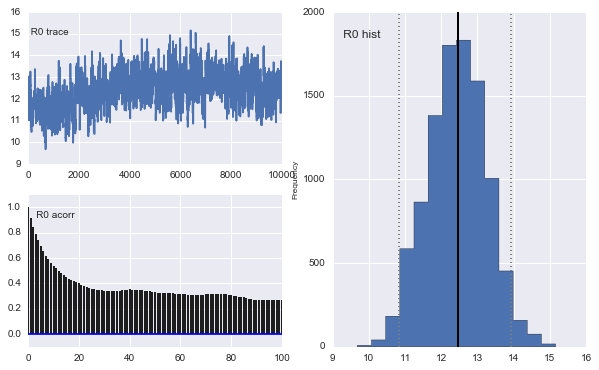

In [43]:
if model_june.R0.value.shape:
    Matplot.summary_plot(model_june.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_june.R0)

Estimate of R0 for june (no confirmation submodel)

Plotting R0


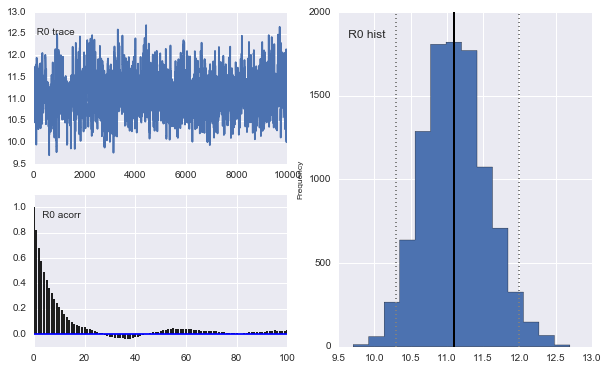

In [44]:
if model_june.R0.value.shape:
    Matplot.summary_plot(model_june_noconf.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_june_noconf.R0)

Estimate of R0 for july (with confirmation submodel)

Plotting R0


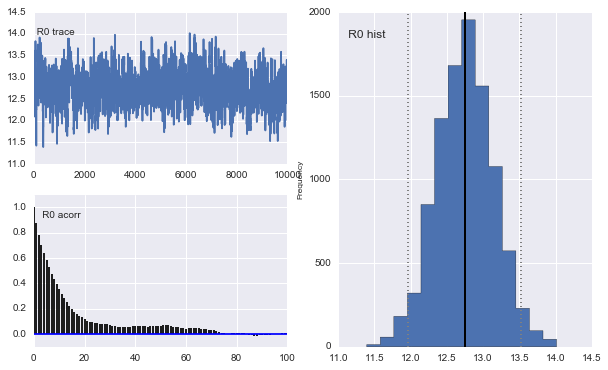

In [45]:
if model_july.β.shape:
    Matplot.summary_plot(model_july.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_july.R0)

Estimate of R0 for july (no confirmation submodel)

Plotting R0


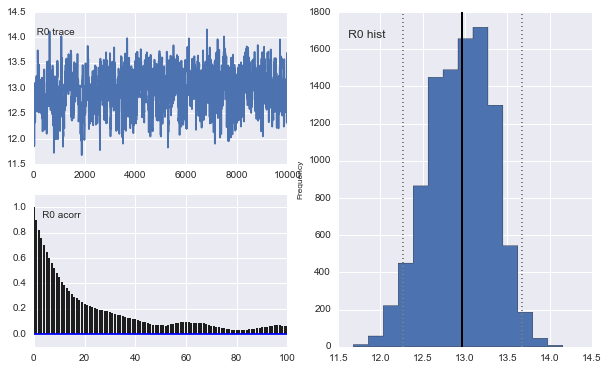

In [46]:
if model_july_noconf.β.shape:
    Matplot.summary_plot(model_july_noconf.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_july_noconf.R0)

Lab confirmation rates, June model

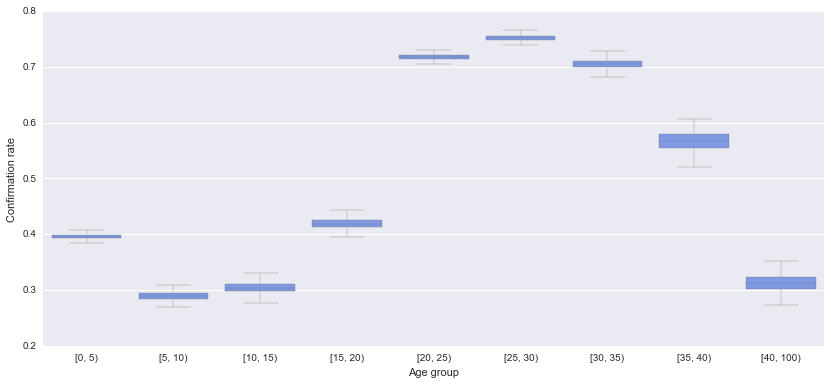

In [47]:
p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

f, axes = plt.subplots(figsize=(14,6))
sb.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
          color=sb.color_palette("coolwarm", 5)[0],
          order=age_group.categories)
axes.set_ylabel('Confirmation rate')
axes.set_xlabel('Age group')

Proportion of **local** population susceptible, June model.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


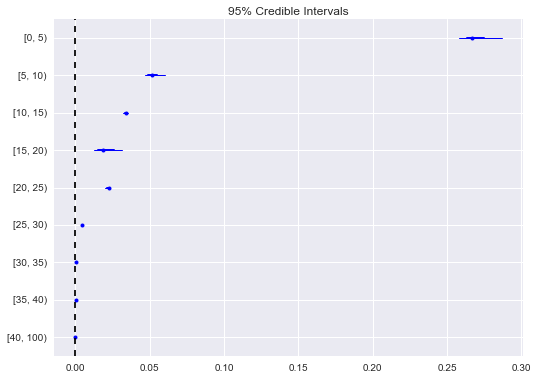

In [48]:
Matplot.summary_plot(model_june.p_susceptible, custom_labels=age_groups)

Proportion of **local** population susceptible, June model with no confirmation correction

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


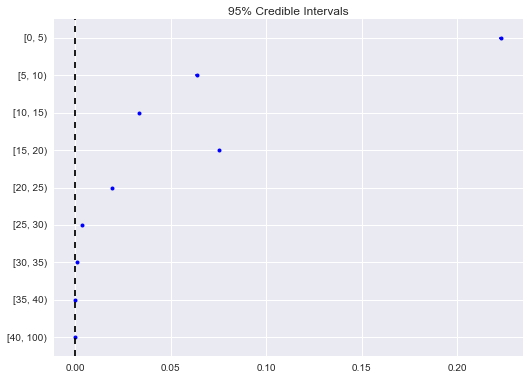

In [49]:
Matplot.summary_plot(model_june_noconf.p_susceptible, custom_labels=age_groups)

Epidemic intensity estimates at June or July observation time, by age group.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


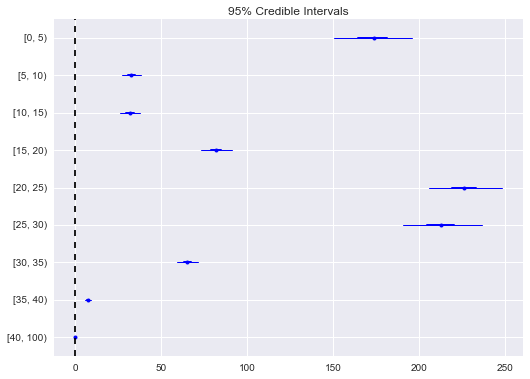

In [50]:
Matplot.summary_plot(model_june.λ_t, custom_labels=age_groups)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


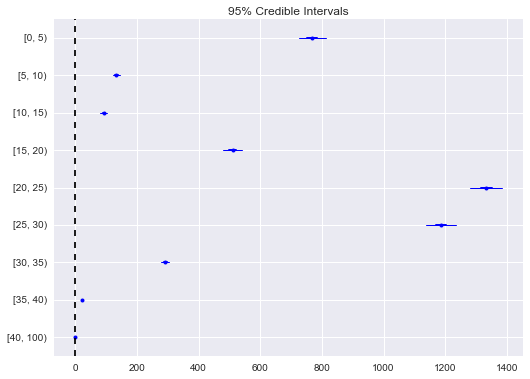

In [51]:
Matplot.summary_plot(model_july.λ_t, custom_labels=age_groups)

Time series of epidemic intensities for lab- versus clinical-confirmation models, for each age group.

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


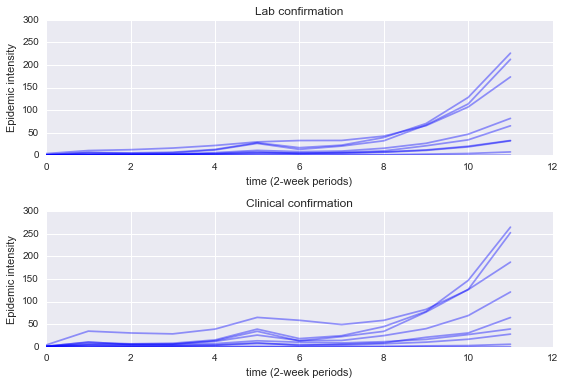

In [52]:
lam_june = model_june.λ.stats()

fig, axes = plt.subplots(2, 1, sharey=True)

axes[0].plot(lam_june['quantiles'][50], 'b-', alpha=0.4)
axes[0].set_ylabel('Epidemic intensity')
axes[0].set_xlabel('time (2-week periods)')
axes[0].set_title('Lab confirmation')

lam_june_noconf = model_june_noconf.λ.stats()

axes[1].plot(lam_june_noconf['quantiles'][50], 'b-', alpha=0.4)
axes[1].set_ylabel('Epidemic intensity')
axes[1].set_xlabel('time (2-week periods)')
axes[1].set_title('Clinical confirmation')

plt.tight_layout()

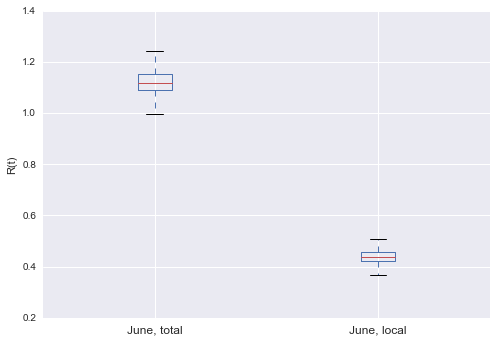

In [53]:
Rt_values = pd.DataFrame(np.c_[model_june.R_t.trace()[:, -1],
                          model_june.R_t_local.trace()[:, -1]],
                        columns=['June, total', 'June, local'])

ax = Rt_values.boxplot(return_type='axes');
ax.set_ylabel('R(t)')

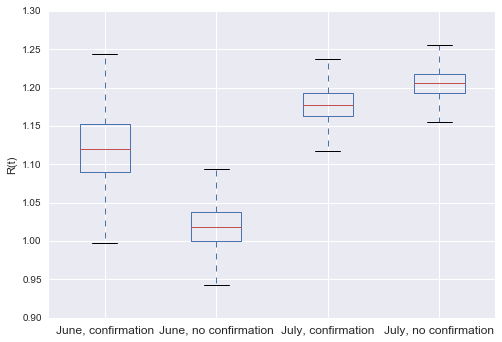

In [54]:
Rt_values = pd.DataFrame(np.c_[model_june.R_t.trace()[:, -1],
                          model_june_noconf.R_t.trace()[:, -1],
                         model_july.R_t.trace()[:, -1],
                         model_july_noconf.R_t.trace()[:, -1]],
                        columns=['June, confirmation', 'June, no confirmation',
                                'July, confirmation', 'July, no confirmation'])

ax = Rt_values.boxplot(return_type='axes', figsize=(14,6));
ax.set_ylabel('R(t)')

In [55]:
S_age_june = pd.DataFrame(model_june.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)

In [56]:
S_age_july = pd.DataFrame(model_july.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)

Numbers of suscepibles in each age group, under lab vs clinical confirmation

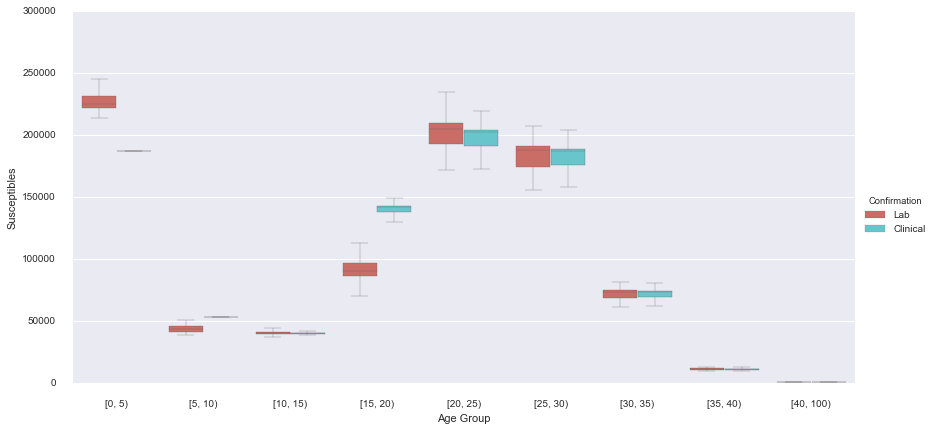

In [57]:
g = sb.factorplot("Age", "S", "Confirmation", S_age_june, kind="box",
                   palette="hls", size=6, aspect=2, linewidth=0.3, fliersize=0, 
                  order=age_group.categories)
g.despine(offset=10, trim=True)
g.set_axis_labels("Age Group", "Susceptibles");

### Vaccination coverage by strategy

In [58]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.245            0.012            0.001            [ 0.224  0.27 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.224            0.238           0.245          0.254         0.269
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.337            0.013            0.001            [ 0.305  0.356]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.312            0.33            0.335          0.348         0.367
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [59]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

In [60]:
june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:9999] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [61]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

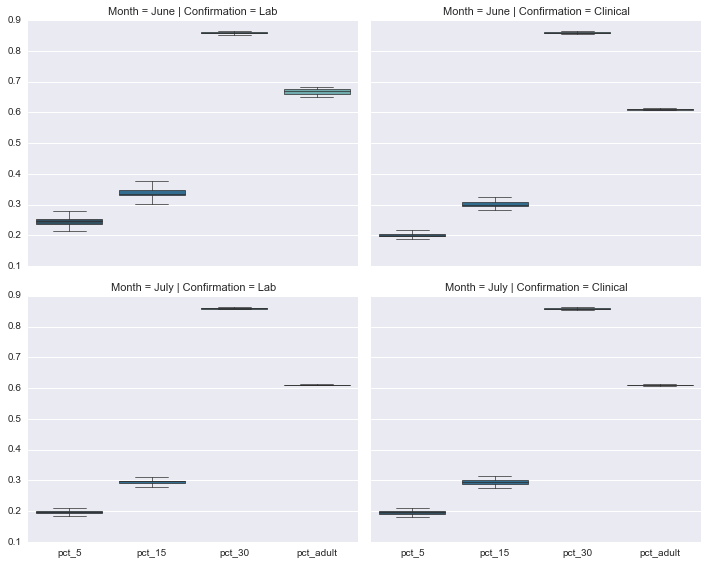

In [62]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

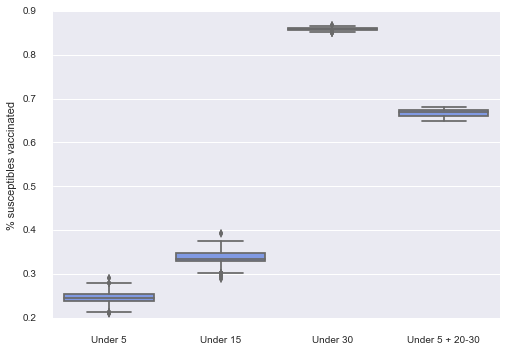

In [63]:
axes = sb.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sb.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sb.despine(offset=10, trim=True)

In [64]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.2              0.006            0.0              [ 0.189  0.209]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.189            0.197           0.198          0.206         0.209
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.299            0.008            0.0              [ 0.284  0.312]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.284            0.296           0.297          0.308         0.312
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [65]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.197            0.004            0.0              [ 0.188  0.205]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.189            0.194           0.198          0.2           0.205
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.296            0.006            0.0              [ 0.283  0.306]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.284            0.291           0.297          0.299         0.306
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [66]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.196            0.005            0.0              [ 0.186  0.202]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.186            0.191           0.196          0.2           0.202
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.295            0.006            0.0              [ 0.281  0.303]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.281            0.288           0.294          0.301         0.303
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Initial migrant susceptibles (June model, with confirmation)

In [67]:
model_june.summary(['N_migrant'])


N_migrant:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	537376.044       38570.255        2196.153     [ 490384.  631167.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	455856.0         501647.0        540381.0       550583.0      628244.0
	


/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


By age group:

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


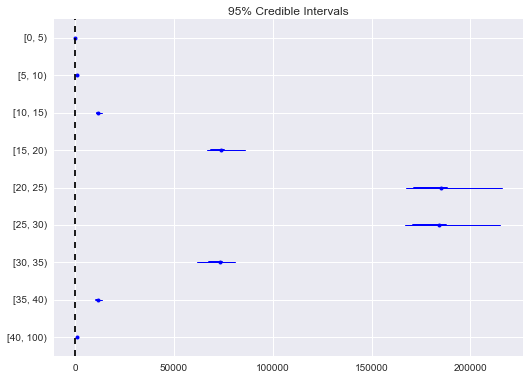

In [68]:
Matplot.summary_plot(model_june.M_0, custom_labels=age_group.categories)

In [69]:
june_r = pd.DataFrame({'local': model_june.trace('R_t_local')[:, -1],
                             'total': model_june.trace('R_t')[:, -1]})
june_r['Month'] = 'June'
june_r['Confirmation'] = 'Lab'

june_noconf_r = pd.DataFrame({'local': model_june_noconf.trace('R_t_local')[:, -1],
                             'total': model_june_noconf.trace('R_t')[:, -1]})
june_noconf_r['Month'] = 'June'
june_noconf_r['Confirmation'] = 'Clinical'

july_r = pd.DataFrame({'local': model_july.trace('R_t_local')[:, -1],
                             'total': model_july.trace('R_t')[:, -1]})
july_r['Month'] = 'July'
july_r['Confirmation'] = 'Lab'

july_noconf_r = pd.DataFrame({'local': model_july_noconf.trace('R_t_local')[:, -1],
                             'total': model_july_noconf.trace('R_t')[:, -1]})
july_noconf_r['Month'] = 'July'
july_noconf_r['Confirmation'] = 'Clinical'

In [70]:
r_estimates = pd.concat([june_r, june_noconf_r, july_r, july_noconf_r], 
                     ignore_index=True)

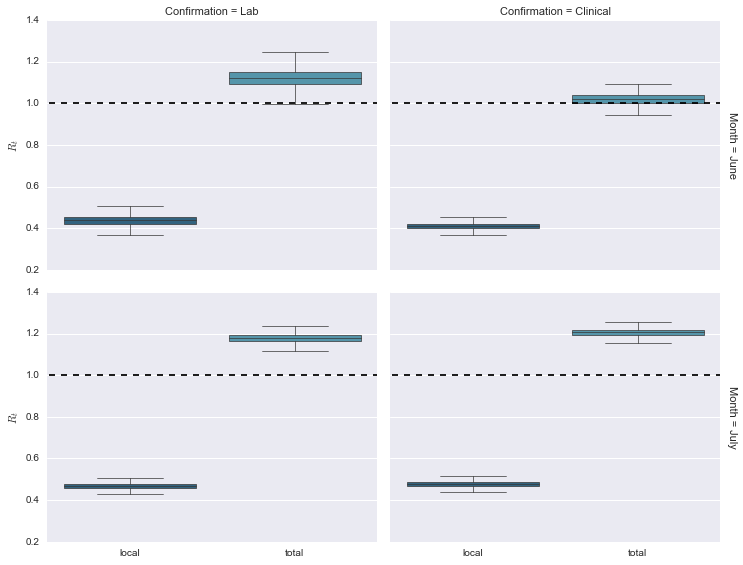

In [71]:
g = sb.factorplot(row="Month", col="Confirmation", data=r_estimates, kind='box',
              row_order=['June', 'July'],
              order=['local', 'total'], margin_titles=True,
            palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)
g.set_ylabels(r"$R_t$")
for ax in g.axes.ravel():
    ax.hlines(1, -1, 2, linestyles='dashed')